# All Tags Above 10 Samples - Balanced Classification Experiment
## Balanced dataset with ALL tags that have >10 samples

This experiment uses ALL tags with >10 samples (not just top 10) to get comprehensive results.
All classes are balanced to equal representation to remove class imbalance bias.

In [1]:
!pip install pandas numpy faiss-gpu-cu12 scikit-learn matplotlib seaborn tqdm sentence-transformers

In [2]:
import sys
import pandas as pd
import numpy as np
from pathlib import Path
import faiss
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import json
import warnings
warnings.filterwarnings('ignore')

print("Imports successful!")

Imports successful!


## Configuration

In [3]:
# Paths
ROOT = Path.cwd()
BASE_DIR = ROOT / "gemini25flash"
CSV_PATH = ROOT / "download_status_with_tags.csv"
RESULTS_DIR = ROOT / "results_all_tags_above_10"
RESULTS_DIR.mkdir(exist_ok=True)

print(f"GE Experiments root: {ROOT}")
print(f"Base directory: {BASE_DIR}")
print(f"  Exists: {BASE_DIR.exists()}")
print(f"CSV path: {CSV_PATH}")
print(f"  Exists: {CSV_PATH.exists()}")
print(f"Results directory: {RESULTS_DIR}")

GE Experiments root: /workspace/embeddings
Base directory: /workspace/embeddings/gemini25flash
  Exists: True
CSV path: /workspace/embeddings/download_status_with_tags.csv
  Exists: True
Results directory: /workspace/embeddings/results_all_tags_above_10


In [4]:
## Load and Balance Data

In [5]:
# Load CSV with tags
df = pd.read_csv(CSV_PATH)
df['doc_name'] = df['filename'].str.replace('.pdf', '', regex=False)
unique_docs = df.drop_duplicates(subset=['doc_name'])

print(f"Loaded {len(unique_docs)} unique documents")
print(f"\nOriginal tag distribution:")
tag_counts = unique_docs['document_tag'].value_counts()
print(tag_counts.head(25))

Loaded 564 unique documents

Original tag distribution:
document_tag
ГИР         67
ГЕОДЕЗ      31
АВИА        31
АВЗУ        29
ЭП          27
ОЧ          26
ПИР         26
МИОРЕК      26
ГЕОЛОГ      26
ОПЗ         24
ПЗЗ         23
ЗНП         19
ПОС         18
ЛИЦГЕН      18
ДЕФАКТ      16
ТУЭС        14
ИНФОЗАК     13
ПП          13
АПЗ         12
НАЧСТРОИ    12
ИНФОГЕН     12
ИСТФИН       9
ЛИЦИЗЫСК     8
ТУТМ         8
ДОЗИМЕТР     7
Name: count, dtype: int64


In [6]:
# Select ALL tags with >10 samples (not just top 10)
MIN_SAMPLES = 10

# Get ALL tags with sufficient samples
valid_tags = tag_counts[tag_counts > MIN_SAMPLES].index.tolist()

print(f"Selected {len(valid_tags)} tags with >{MIN_SAMPLES} samples:")
for tag in valid_tags:
    count = tag_counts[tag]
    print(f"  {tag}: {count} samples")

# Filter dataset to only include selected tags
filtered_docs = unique_docs[unique_docs['document_tag'].isin(valid_tags)].copy()
print(f"\nFiltered dataset: {len(filtered_docs)} documents")

Selected 21 tags with >10 samples:
  ГИР: 67 samples
  ГЕОДЕЗ: 31 samples
  АВИА: 31 samples
  АВЗУ: 29 samples
  ЭП: 27 samples
  ОЧ: 26 samples
  ПИР: 26 samples
  МИОРЕК: 26 samples
  ГЕОЛОГ: 26 samples
  ОПЗ: 24 samples
  ПЗЗ: 23 samples
  ЗНП: 19 samples
  ПОС: 18 samples
  ЛИЦГЕН: 18 samples
  ДЕФАКТ: 16 samples
  ТУЭС: 14 samples
  ИНФОЗАК: 13 samples
  ПП: 13 samples
  АПЗ: 12 samples
  НАЧСТРОИ: 12 samples
  ИНФОГЕН: 12 samples

Filtered dataset: 483 documents


In [7]:
# Balance the dataset: use min class size to avoid overrepresentation
# This ensures no class dominates the results
min_class_size = filtered_docs['document_tag'].value_counts().min()

print(f"Minimum class size: {min_class_size}")
print(f"Balancing all {len(valid_tags)} classes to {min_class_size} samples each")

# Sample equal number from each class
balanced_docs = []
np.random.seed(42)  # For reproducibility

for tag in valid_tags:
    tag_docs = filtered_docs[filtered_docs['document_tag'] == tag]
    sampled_docs = tag_docs.sample(n=min_class_size, random_state=42)
    balanced_docs.append(sampled_docs)

balanced_dataset = pd.concat(balanced_docs, ignore_index=True)

print(f"\nBalanced dataset: {len(balanced_dataset)} documents")
print(f"Expected: {len(valid_tags)} tags × {min_class_size} samples = {len(valid_tags) * min_class_size}")
print(f"\nBalanced distribution:")
print(balanced_dataset['document_tag'].value_counts().sort_index())

Minimum class size: 12
Balancing all 21 classes to 12 samples each

Balanced dataset: 252 documents
Expected: 21 tags × 12 samples = 252

Balanced distribution:
document_tag
АВЗУ        12
АВИА        12
АПЗ         12
ГЕОДЕЗ      12
ГЕОЛОГ      12
ГИР         12
ДЕФАКТ      12
ЗНП         12
ИНФОГЕН     12
ИНФОЗАК     12
ЛИЦГЕН      12
МИОРЕК      12
НАЧСТРОИ    12
ОПЗ         12
ОЧ          12
ПЗЗ         12
ПИР         12
ПОС         12
ПП          12
ТУЭС        12
ЭП          12
Name: count, dtype: int64


## Initialize Services

In [8]:
from text_selector import TextSelector
text_selector = TextSelector(BASE_DIR)
print("Text selector initialized")


Text selector initialized


## Define Experiment Strategies

Same strategies as original experiment for direct comparison

In [9]:
# Define strategies - same as original for comparison
strategies = [
    # First N pages
    {'name': 'first_1_page', 'config': {'type': 'first_n', 'n': 1}},
    {'name': 'first_2_pages', 'config': {'type': 'first_n', 'n': 2}},
    {'name': 'first_3_pages', 'config': {'type': 'first_n', 'n': 3}},
    {'name': 'first_5_pages', 'config': {'type': 'first_n', 'n': 5}},
    
    # Last N pages
    {'name': 'last_1_page', 'config': {'type': 'last_n', 'n': 1}},
    {'name': 'last_2_pages', 'config': {'type': 'last_n', 'n': 2}},
    
    # First and last
    {'name': 'first_and_last_1', 'config': {'type': 'first_and_last', 'n': 1}},
    {'name': 'first_and_last_2', 'config': {'type': 'first_and_last', 'n': 2}},
    
    # Middle pages
    {'name': 'middle_3_pages', 'config': {'type': 'middle_n', 'n': 3}},
    {'name': 'middle_5_pages', 'config': {'type': 'middle_n', 'n': 5}},
    
    # Percentage-based
    {'name': 'first_5_percent', 'config': {'type': 'percentage', 'percentage': 0.05, 'position': 'start'}},
    {'name': 'first_10_percent', 'config': {'type': 'percentage', 'percentage': 0.10, 'position': 'start'}},
    {'name': 'middle_5_percent', 'config': {'type': 'percentage', 'percentage': 0.05, 'position': 'middle'}},
    
    # Character-based
    {'name': 'first_1000_chars', 'config': {'type': 'first_chars', 'n_chars': 1000}},
    {'name': 'first_2000_chars', 'config': {'type': 'first_chars', 'n_chars': 2000}},
    {'name': 'first_5000_chars', 'config': {'type': 'first_chars', 'n_chars': 5000}},
    
    # Baseline
    {'name': 'all_pages', 'config': {'type': 'all'}},
]

print(f"Defined {len(strategies)} strategies to test")

Defined 17 strategies to test


## Text Preprocessing

Lightweight text cleaning - no heavy libraries, just regex and string operations.

In [10]:
import re
from pathlib import Path

# Load stopwords
STOPWORDS_DIR = Path.cwd()
STOPWORDS_RU = set()
STOPWORDS_KZ = set()

# Load Russian stopwords
ru_path = STOPWORDS_DIR / "stopwords-ru.txt"
if ru_path.exists():
    with open(ru_path, 'r', encoding='utf-8') as f:
        STOPWORDS_RU = set(line.strip().lower() for line in f if line.strip())
    print(f"Loaded {len(STOPWORDS_RU)} Russian stopwords")

# Load Kazakh stopwords
kz_path = STOPWORDS_DIR / "stopwords-kz.txt"
if kz_path.exists():
    with open(kz_path, 'r', encoding='utf-8') as f:
        STOPWORDS_KZ = set(line.strip().lower() for line in f if line.strip())
    print(f"Loaded {len(STOPWORDS_KZ)} Kazakh stopwords")

# Combined stopwords
ALL_STOPWORDS = STOPWORDS_RU | STOPWORDS_KZ
print(f"Total unique stopwords: {len(ALL_STOPWORDS)}")


def remove_stopwords_from_text(text: str, stopwords: set = None) -> str:
    """
    Remove stopwords from text while preserving structure.
    Uses word boundary matching to avoid partial matches.
    """
    if stopwords is None:
        stopwords = ALL_STOPWORDS
    
    if not stopwords:
        return text
    
    # Split into words, filter, rejoin
    words = text.split()
    filtered_words = [word for word in words if word.lower().strip('.,;:!?()"\'-') not in stopwords]
    return ' '.join(filtered_words)


def preprocess_text(text: str, remove_stopwords: bool = False) -> str:
    """
    Clean OCR text - remove noise, normalize whitespace, strip formatting artifacts.
    No heavy libraries - just regex and string ops.
    
    Args:
        text: Input text to preprocess
        remove_stopwords: Whether to remove Russian/Kazakh stopwords (default False)
                         Note: Not recommended for transformer embeddings as it may hurt quality
    """
    if not text:
        return ""
    
    # Remove Gemini OCR artifacts - seal/image descriptions in brackets
    text = re.sub(r'\[Seal text:.*?\]', '', text, flags=re.IGNORECASE | re.DOTALL)
    text = re.sub(r'\[Image:.*?\]', '', text, flags=re.IGNORECASE | re.DOTALL)
    
    # Remove signature/form field markers
    text = re.sub(r'\(подпись\)', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\(signature\)', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\(Т\.?А\.?Ә\.?\)\s*\(Ф\.?И\.?О\.?\)', '', text)  # (Т.А.Ә)(Ф.И.О)
    text = re.sub(r'\(Ф\.?И\.?О\.?\)', '', text)
    
    # Remove form field instructions in parentheses (common patterns)
    text = re.sub(r'\(указывается [^)]+\)', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\(дата и время [^)]+\)', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\(фамилия, имя, отчество[^)]*\)', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\(наименование [^)]+\)', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\(при его наличии\)', '', text, flags=re.IGNORECASE)
    
    # Remove elicense.kz disclaimers (they appear on every page)
    text = re.sub(r'Бұл құжат ҚР.*?www\.elicense\.kz\.?', '', text, flags=re.DOTALL)
    text = re.sub(r'Данный документ согласно.*?www\.elicense\.kz\.?', '', text, flags=re.DOTALL)
    text = re.sub(r'Электрондық құжат.*?www\.elicense\.kz\.?', '', text, flags=re.DOTALL)
    text = re.sub(r'Электронный документ.*?www\.elicense\.kz\.?', '', text, flags=re.DOTALL)
    
    # Remove page numbers and headers/footers patterns
    text = re.sub(r'(?:Страница|Page|Стр\.?)\s*\d+\s*(?:из|of|/)\s*\d+', '', text, flags=re.IGNORECASE)
    text = re.sub(r'^\s*[-–—]\s*\d+\s*[-–—]\s*$', '', text, flags=re.MULTILINE)
    text = re.sub(r'^\s*\d+\s*$', '', text, flags=re.MULTILINE)  # Standalone page numbers
    text = re.sub(r'^\d+-\d+\s*$', '', text, flags=re.MULTILINE)  # Page ranges like "1-9"
    
    # Remove excessive punctuation sequences (OCR artifacts)
    text = re.sub(r'[.]{3,}', '...', text)  # Keep max 3 dots
    text = re.sub(r'[-_=]{3,}', ' ', text)  # Remove separator lines
    text = re.sub(r'[*#@]{2,}', '', text)   # Remove decorative chars
    
    # Remove table-like formatting artifacts
    text = re.sub(r'\|+', ' ', text)  # Pipe chars from tables
    text = re.sub(r'\+[-+]+\+', '', text)  # ASCII table borders
    
    # Normalize quotes and dashes
    text = re.sub(r'[«»""„]', '"', text)  # Normalize quotes
    text = re.sub(r'[–—]', '-', text)      # Normalize dashes
    
    # Remove non-printable and control characters (except newlines/tabs)
    text = re.sub(r'[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\x9f]', '', text)
    
    # Remove excessive whitespace
    text = re.sub(r'[ \t]+', ' ', text)           # Multiple spaces/tabs -> single space
    text = re.sub(r'\n{3,}', '\n\n', text)        # Max 2 newlines
    text = re.sub(r'^\s+', '', text, flags=re.MULTILINE)  # Leading whitespace per line
    
    # Optional: Remove stopwords (NOT recommended for transformer embeddings)
    if remove_stopwords:
        text = remove_stopwords_from_text(text)
    
    # Final trim
    text = text.strip()
    
    return text


# Test preprocessing
test_text = """
    1-9
    
    «УТВЕРЖДАЮ»
    Директор ТОО «Компания»
    Иванов И.И.
    (подпись)
    (Т.А.Ә)(Ф.И.О)
    [Seal text: КАЗАКСТАН РЕСПУБЛИКАСЫ]
    
    Это важный документ для рассмотрения.
    Бұл маңызды құжат қарау үшін.
    
    Бұл құжат ҚР 2003 жылдың 7 қаңтарындағы «Электронды құжат және электронды сандық қол қою» туралы заңның 7 бабы, 1 тармағына сәйкес қағаз бетіндегі заңмен тең.
    Электрондық құжат www.elicense.kz порталында құрылған.
"""

print("\n--- Test WITHOUT stopword removal (default) ---")
cleaned = preprocess_text(test_text, remove_stopwords=False)
print(f"Length: {len(cleaned)}")
print(cleaned)

print("\n--- Test WITH stopword removal ---")
cleaned_no_stop = preprocess_text(test_text, remove_stopwords=True)
print(f"Length: {len(cleaned_no_stop)}")
print(cleaned_no_stop)

print("\nPreprocessing function defined")

Loaded 559 Russian stopwords
Loaded 322 Kazakh stopwords
Total unique stopwords: 875

--- Test WITHOUT stopword removal (default) ---
Length: 140
1-9
"УТВЕРЖДАЮ"
Директор ТОО "Компания"
Иванов И.И.
Это важный документ для рассмотрения.
Бұл маңызды құжат қарау үшін.
порталында құрылған.

--- Test WITH stopword removal ---
Length: 115
1-9 "УТВЕРЖДАЮ" Директор ТОО "Компания" Иванов И.И. документ рассмотрения. маңызды құжат қарау порталында құрылған.

Preprocessing function defined


In [11]:
import json
import shutil

# Configuration for preprocessing
REMOVE_STOPWORDS = True  # Set to True if you want to remove stopwords (not recommended)

# Output directory for preprocessed documents
PREPROCESSED_DIR = ROOT / "gemini25flash_preprocessed_stopwords"
PREPROCESSED_DIR.mkdir(exist_ok=True)

print(f"Preprocessing documents from: {BASE_DIR}")
print(f"Saving to: {PREPROCESSED_DIR}")
print(f"Remove stopwords: {REMOVE_STOPWORDS}")

# Get all document folders
doc_folders = [f for f in BASE_DIR.iterdir() if f.is_dir()]
print(f"Found {len(doc_folders)} document folders")

# Process each document
processed_count = 0
skipped_count = 0

for doc_folder in tqdm(doc_folders, desc="Preprocessing documents"):
    doc_name = doc_folder.name
    output_folder = PREPROCESSED_DIR / doc_name
    output_folder.mkdir(exist_ok=True)
    
    # Get all JSON files in the document folder
    json_files = sorted(doc_folder.glob("*.json"), key=lambda x: int(x.stem) if x.stem.isdigit() else 0)
    
    if not json_files:
        skipped_count += 1
        continue
    
    for json_file in json_files:
        try:
            # Read original JSON
            with open(json_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            # Get and preprocess text
            original_text = data.get('text', '')
            preprocessed_text = preprocess_text(original_text, remove_stopwords=REMOVE_STOPWORDS)
            
            # Update data with preprocessed text
            data['text'] = preprocessed_text
            data['original_text'] = original_text  # Keep original for reference
            data['preprocessing'] = {
                'remove_stopwords': REMOVE_STOPWORDS,
                'original_length': len(original_text),
                'preprocessed_length': len(preprocessed_text),
                'reduction_percent': round((1 - len(preprocessed_text) / len(original_text)) * 100, 2) if original_text else 0
            }
            
            # Save preprocessed JSON
            output_path = output_folder / json_file.name
            with open(output_path, 'w', encoding='utf-8') as f:
                json.dump(data, f, ensure_ascii=False, indent=2)
            
        except Exception as e:
            print(f"Error processing {json_file}: {e}")
            continue
    
    processed_count += 1

print(f"\nPreprocessing complete!")
print(f"Processed: {processed_count} documents")
print(f"Skipped (empty): {skipped_count} documents")
print(f"Output directory: {PREPROCESSED_DIR}")

Preprocessing documents from: /workspace/embeddings/gemini25flash
Saving to: /workspace/embeddings/gemini25flash_preprocessed_stopwords
Remove stopwords: True
Found 532 document folders


Preprocessing documents:   0%|          | 0/532 [00:00<?, ?it/s]


Preprocessing complete!
Processed: 532 documents
Skipped (empty): 0 documents
Output directory: /workspace/embeddings/gemini25flash_preprocessed_stopwords


In [12]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("google/embeddinggemma-300m", trust_remote_code=True)

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda:0
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: google/embeddinggemma-300m
INFO:sentence_transformers.SentenceTransformer:14 prompts are loaded, with the keys: ['query', 'document', 'BitextMining', 'Clustering', 'Classification', 'InstructionRetrieval', 'MultilabelClassification', 'PairClassification', 'Reranking', 'Retrieval', 'Retrieval-query', 'Retrieval-document', 'STS', 'Summarization']


## Save Preprocessed Documents

Save all preprocessed documents to a new folder with the same structure as the original.

In [13]:
def extract_texts_for_strategy(df, strategy_config, use_preprocessing=True, use_preprocessed_dir=True):
    """
    Extract texts for all documents using a given strategy.
    
    Args:
        df: DataFrame with documents
        strategy_config: Strategy configuration dict
        use_preprocessing: Whether to clean the text on-the-fly (default True)
        use_preprocessed_dir: Whether to read from preprocessed directory (default True)
                             If True, reads from gemini25flash_preprocessed/
                             If False, reads from gemini25flash/ and optionally preprocesses
    
    Returns:
        List of (doc_name, text, tag, file_type) tuples
    """
    results = []
    
    # Choose source directory
    if use_preprocessed_dir and PREPROCESSED_DIR.exists():
        source_selector = TextSelector(PREPROCESSED_DIR)
        print(f"  Using preprocessed directory: {PREPROCESSED_DIR}")
    else:
        source_selector = text_selector
        if use_preprocessed_dir:
            print(f"  Warning: Preprocessed directory not found, using original")
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting texts"):
        doc_name = row['doc_name']
        tag = row['document_tag']
        file_type = row['file_type']
        
        try:
            text = source_selector.select_by_strategy(doc_name, strategy_config)
            
            # Apply preprocessing on-the-fly only if NOT using preprocessed dir
            if use_preprocessing and not use_preprocessed_dir:
                text = preprocess_text(text)
            
            if text.strip():
                results.append((doc_name, text, tag, file_type))
            else:
                print(f"  Warning: Empty text for {doc_name}")
        except Exception as e:
            print(f"  Error processing {doc_name}: {e}")
    
    return results


def embed_texts(texts, batch_size=32):
    """
    Embed texts using SentenceTransformer model.
    
    Args:
        texts: List of strings to embed
        model: SentenceTransformer model instance
        batch_size: Batch size for encoding
    
    Returns:
        numpy array of embeddings
    """
    if not texts:
        return np.array([])
    
    print(f"Embedding {len(texts)} texts...")
    
    # Use encode_document for document embeddings
    embeddings = model.encode(
        texts,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True
    )
    
    print(f"Generated {len(embeddings)} embeddings with shape {embeddings.shape}")
    
    return embeddings


def classify_with_faiss(train_embeddings, train_labels, test_embeddings, k=5):
    """
    Classify using FAISS k-NN with cosine similarity.
    """
    # Normalize for cosine similarity
    faiss.normalize_L2(train_embeddings)
    faiss.normalize_L2(test_embeddings)
    
    # Build FAISS index
    dim = train_embeddings.shape[1]
    index = faiss.IndexFlatIP(dim)
    index.add(train_embeddings)
    
    # Search k nearest neighbors
    distances, indices = index.search(test_embeddings, k)
    
    # Majority vote
    predictions = []
    for neighbor_indices in indices:
        neighbor_labels = train_labels[neighbor_indices]
        unique, counts = np.unique(neighbor_labels, return_counts=True)
        prediction = unique[np.argmax(counts)]
        predictions.append(prediction)
    
    return np.array(predictions)


def calculate_metrics(y_true, y_pred, strategy_name):
    """
    Calculate classification metrics.
    For balanced data, macro-average is more appropriate.
    """
    accuracy = accuracy_score(y_true, y_pred)
    
    # Use macro average for balanced datasets (equal weight to each class)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    
    # Also calculate weighted for comparison
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )
    
    return {
        'strategy': strategy_name,
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
    }

print("Helper functions defined (with text preprocessing enabled)")

Helper functions defined (with text preprocessing enabled)


## Run Experiments with Stratified Split

Using stratified split to ensure balanced class distribution in train/test sets

In [14]:
# Configuration
np.random.seed(42)
TRAIN_RATIO = 0.8
K_NEIGHBORS = 5

NUM_TAGS = len(valid_tags)

# Calculate baseline accuracy (random guessing)
BASELINE_RANDOM = 1.0 / NUM_TAGS

all_results = []

print(f"Running balanced experiments:")
print(f"  Dataset: {len(balanced_dataset)} documents ({NUM_TAGS} classes × {min_class_size} samples)")
print(f"  Train/test split: {TRAIN_RATIO*100:.0f}% / {(1-TRAIN_RATIO)*100:.0f}%")
print(f"  K-NN k-value: {K_NEIGHBORS}")
print(f"  Baseline (random): {BASELINE_RANDOM*100:.1f}% accuracy")
print(f"  Using stratified split to maintain class balance\n")

Running balanced experiments:
  Dataset: 252 documents (21 classes × 12 samples)
  Train/test split: 80% / 20%
  K-NN k-value: 5
  Baseline (random): 4.8% accuracy
  Using stratified split to maintain class balance



In [15]:
# Run experiments
for strategy in strategies:
    strategy_name = strategy['name']
    strategy_config = strategy['config']
    
    print(f"\n{'='*80}")
    print(f"Strategy: {strategy_name}")
    print(f"Config: {strategy_config}")
    print(f"{'='*80}")
    
    try:
        # Extract texts
        print("\n1. Extracting texts...")
        text_data = extract_texts_for_strategy(balanced_dataset, strategy_config)
        
        if len(text_data) == 0:
            print(f"  ✗ No texts extracted")
            continue
        
        print(f"  ✓ Extracted {len(text_data)} documents")
        
        # Unpack data
        doc_names = [item[0] for item in text_data]
        texts = [item[1] for item in text_data]
        labels = np.array([item[2] for item in text_data])
        file_types = [item[3] for item in text_data]
        
        # Generate embeddings
        print("\n2. Generating embeddings...")
        embeddings = embed_texts(texts)
        
        if len(embeddings) == 0:
            print(f"  ✗ No embeddings generated")
            continue
        
        print(f"  ✓ Generated {len(embeddings)} embeddings (shape: {embeddings.shape})")
        
        # Align embeddings and labels
        min_len = min(len(embeddings), len(labels))
        embeddings = embeddings[:min_len]
        labels = labels[:min_len]
        
        # Stratified split
        print("\n3. Stratified train/test split...")
        from sklearn.model_selection import train_test_split
        
        indices = np.arange(len(embeddings))
        train_indices, test_indices = train_test_split(
            indices, 
            test_size=(1-TRAIN_RATIO), 
            stratify=labels,
            random_state=42
        )
        
        train_embeddings = embeddings[train_indices].astype('float32')
        train_labels = labels[train_indices]
        test_embeddings = embeddings[test_indices].astype('float32')
        test_labels = labels[test_indices]
        
        print(f"  Train: {len(train_embeddings)} samples")
        print(f"  Test: {len(test_embeddings)} samples")
        
        # Verify stratification - show distribution
        train_unique, train_counts = np.unique(train_labels, return_counts=True)
        test_unique, test_counts = np.unique(test_labels, return_counts=True)
        print(f"  Train classes: {len(train_unique)}, samples per class: {train_counts}")
        print(f"  Test classes: {len(test_unique)}, samples per class: {test_counts}")
        
        # Classify
        print("\n4. Classifying with FAISS k-NN...")
        predictions = classify_with_faiss(train_embeddings, train_labels, test_embeddings, k=K_NEIGHBORS)
        
        # Calculate metrics
        print("\n5. Calculating metrics...")
        metrics = calculate_metrics(test_labels, predictions, strategy_name)
        all_results.append(metrics)
        
        # Print results
        print(f"\n{'─'*80}")
        print(f"Results for {strategy_name}:")
        print(f"  Accuracy:         {metrics['accuracy']:.4f}")
        print(f"  F1 (macro):       {metrics['f1_macro']:.4f}")
        print(f"  F1 (weighted):    {metrics['f1_weighted']:.4f}")
        print(f"  Precision (macro): {metrics['precision_macro']:.4f}")
        print(f"  Recall (macro):    {metrics['recall_macro']:.4f}")
        print(f"{'─'*80}")
        
        # Classification report
        print("\nPer-class metrics:")
        print(classification_report(test_labels, predictions, zero_division=0))
        
    except Exception as e:
        print(f"\n✗ Error: {e}")
        import traceback
        traceback.print_exc()
        continue

print(f"\n\n{'='*80}")
print(f"Completed {len(all_results)} / {len(strategies)} experiments")
print(f"{'='*80}")


Strategy: first_1_page
Config: {'type': 'first_n', 'n': 1}

1. Extracting texts...
  Using preprocessed directory: /workspace/embeddings/gemini25flash_preprocessed_stopwords


Extracting texts:   0%|          | 0/252 [00:00<?, ?it/s]

  Error processing Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный 

  Error processing Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1'


  ✓ Extracted 218 documents

2. Generating embeddings...
Embedding 218 texts...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Generated 218 embeddings with shape (218, 768)
  ✓ Generated 218 embeddings (shape: (218, 768))

3. Stratified train/test split...
  Train: 174 samples
  Test: 44 samples
  Train classes: 21, samples per class: [ 3 10  9  9  9  8  9  9 10  9  6 10  6  9  9  4  7  9  9 10 10]
  Test classes: 21, samples per class: [1 2 2 3 2 2 3 2 2 3 2 2 1 3 2 1 2 3 2 2 2]

4. Classifying with FAISS k-NN...

5. Calculating metrics...

────────────────────────────────────────────────────────────────────────────────
Results for first_1_page:
  Accuracy:         0.6364
  F1 (macro):       0.5617
  F1 (weighted):    0.5936
  Precision (macro): 0.5635
  Recall (macro):    0.6111
────────────────────────────────────────────────────────────────────────────────

Per-class metrics:
              precision    recall  f1-score   support

        АВЗУ       1.00      1.00      1.00         1
        АВИА       0.50      1.00      0.67         2
         АПЗ       0.50      1.00      0.67         2
      ГЕОДЕЗ    

Extracting texts:   0%|          | 0/252 [00:00<?, ?it/s]

  Error processing Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный 

  Error processing Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1'


  ✓ Extracted 221 documents

2. Generating embeddings...
Embedding 221 texts...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Generated 221 embeddings with shape (221, 768)
  ✓ Generated 221 embeddings (shape: (221, 768))

3. Stratified train/test split...
  Train: 176 samples
  Test: 45 samples
  Train classes: 21, samples per class: [ 3 10  9  9  9  9  9 10  9 10  6  9  6  9  9  4  7 10 10  9 10]
  Test classes: 21, samples per class: [1 2 2 3 2 2 3 2 3 2 2 3 1 3 2 1 2 2 2 3 2]

4. Classifying with FAISS k-NN...

5. Calculating metrics...

────────────────────────────────────────────────────────────────────────────────
Results for first_2_pages:
  Accuracy:         0.4889
  F1 (macro):       0.4429
  F1 (weighted):    0.4778
  Precision (macro): 0.4484
  Recall (macro):    0.4683
────────────────────────────────────────────────────────────────────────────────

Per-class metrics:
              precision    recall  f1-score   support

        АВЗУ       0.33      1.00      0.50         1
        АВИА       1.00      1.00      1.00         2
         АПЗ       0.33      0.50      0.40         2
      ГЕОДЕЗ   

Extracting texts:   0%|          | 0/252 [00:00<?, ?it/s]

  Error processing Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный 

  Error processing Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1'


  ✓ Extracted 221 documents

2. Generating embeddings...
Embedding 221 texts...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Generated 221 embeddings with shape (221, 768)
  ✓ Generated 221 embeddings (shape: (221, 768))

3. Stratified train/test split...
  Train: 176 samples
  Test: 45 samples
  Train classes: 21, samples per class: [ 3 10  9  9  9  9  9 10  9 10  6  9  6  9  9  4  7 10 10  9 10]
  Test classes: 21, samples per class: [1 2 2 3 2 2 3 2 3 2 2 3 1 3 2 1 2 2 2 3 2]

4. Classifying with FAISS k-NN...

5. Calculating metrics...

────────────────────────────────────────────────────────────────────────────────
Results for first_3_pages:
  Accuracy:         0.5778
  F1 (macro):       0.5501
  F1 (weighted):    0.5683
  Precision (macro): 0.5571
  Recall (macro):    0.5714
────────────────────────────────────────────────────────────────────────────────

Per-class metrics:
              precision    recall  f1-score   support

        АВЗУ       0.50      1.00      0.67         1
        АВИА       1.00      1.00      1.00         2
         АПЗ       0.20      0.50      0.29         2
      ГЕОДЕЗ   

Extracting texts:   0%|          | 0/252 [00:00<?, ?it/s]

  Error processing Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3'


  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_9: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_9'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный уч

  Error processing Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1'


  ✓ Extracted 221 documents

2. Generating embeddings...
Embedding 221 texts...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Generated 221 embeddings with shape (221, 768)
  ✓ Generated 221 embeddings (shape: (221, 768))

3. Stratified train/test split...
  Train: 176 samples
  Test: 45 samples
  Train classes: 21, samples per class: [ 3 10  9  9  9  9  9 10  9 10  6  9  6  9  9  4  7 10 10  9 10]
  Test classes: 21, samples per class: [1 2 2 3 2 2 3 2 3 2 2 3 1 3 2 1 2 2 2 3 2]

4. Classifying with FAISS k-NN...

5. Calculating metrics...

────────────────────────────────────────────────────────────────────────────────
Results for first_5_pages:
  Accuracy:         0.5556
  F1 (macro):       0.4551
  F1 (weighted):    0.5031
  Precision (macro): 0.4286
  Recall (macro):    0.5159
────────────────────────────────────────────────────────────────────────────────

Per-class metrics:
              precision    recall  f1-score   support

        АВЗУ       0.50      1.00      0.67         1
        АВИА       1.00      1.00      1.00         2
         АПЗ       0.25      1.00      0.40         2
      ГЕОДЕЗ   

Extracting texts:   0%|          | 0/252 [00:00<?, ?it/s]

  Error processing Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный 

  Error processing Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1'


  ✓ Extracted 217 documents

2. Generating embeddings...
Embedding 217 texts...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Generated 217 embeddings with shape (217, 768)
  ✓ Generated 217 embeddings (shape: (217, 768))

3. Stratified train/test split...
  Train: 173 samples
  Test: 44 samples
  Train classes: 21, samples per class: [ 3 10  9  9  8  9  9  9 10  9  6  9  6  9  9  4  7  9 10  9 10]
  Test classes: 21, samples per class: [1 2 2 3 2 2 3 2 2 3 1 3 1 3 2 1 2 2 2 3 2]

4. Classifying with FAISS k-NN...

5. Calculating metrics...

────────────────────────────────────────────────────────────────────────────────
Results for last_1_page:
  Accuracy:         0.4545
  F1 (macro):       0.3825
  F1 (weighted):    0.4061
  Precision (macro): 0.4087
  Recall (macro):    0.4365
────────────────────────────────────────────────────────────────────────────────

Per-class metrics:
              precision    recall  f1-score   support

        АВЗУ       1.00      1.00      1.00         1
        АВИА       0.33      1.00      0.50         2
         АПЗ       0.25      1.00      0.40         2
      ГЕОДЕЗ     

Extracting texts:   0%|          | 0/252 [00:00<?, ?it/s]

  Error processing Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный 

  Error processing Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1'


  ✓ Extracted 221 documents

2. Generating embeddings...
Embedding 221 texts...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Generated 221 embeddings with shape (221, 768)
  ✓ Generated 221 embeddings (shape: (221, 768))

3. Stratified train/test split...
  Train: 176 samples
  Test: 45 samples
  Train classes: 21, samples per class: [ 3 10  9  9  9  9  9 10  9 10  6  9  6  9  9  4  7 10 10  9 10]
  Test classes: 21, samples per class: [1 2 2 3 2 2 3 2 3 2 2 3 1 3 2 1 2 2 2 3 2]

4. Classifying with FAISS k-NN...

5. Calculating metrics...

────────────────────────────────────────────────────────────────────────────────
Results for last_2_pages:
  Accuracy:         0.5333
  F1 (macro):       0.4546
  F1 (weighted):    0.4735
  Precision (macro): 0.4556
  Recall (macro):    0.5238
────────────────────────────────────────────────────────────────────────────────

Per-class metrics:
              precision    recall  f1-score   support

        АВЗУ       1.00      1.00      1.00         1
        АВИА       0.50      1.00      0.67         2
         АПЗ       0.33      1.00      0.50         2
      ГЕОДЕЗ    

Extracting texts:   0%|          | 0/252 [00:00<?, ?it/s]

  Error processing Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный 

  Error processing Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1'


  ✓ Extracted 221 documents

2. Generating embeddings...
Embedding 221 texts...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Generated 221 embeddings with shape (221, 768)
  ✓ Generated 221 embeddings (shape: (221, 768))

3. Stratified train/test split...
  Train: 176 samples
  Test: 45 samples
  Train classes: 21, samples per class: [ 3 10  9  9  9  9  9 10  9 10  6  9  6  9  9  4  7 10 10  9 10]
  Test classes: 21, samples per class: [1 2 2 3 2 2 3 2 3 2 2 3 1 3 2 1 2 2 2 3 2]

4. Classifying with FAISS k-NN...

5. Calculating metrics...

────────────────────────────────────────────────────────────────────────────────
Results for first_and_last_1:
  Accuracy:         0.4667
  F1 (macro):       0.3839
  F1 (weighted):    0.3912
  Precision (macro): 0.3446
  Recall (macro):    0.4841
────────────────────────────────────────────────────────────────────────────────

Per-class metrics:
              precision    recall  f1-score   support

        АВЗУ       0.33      1.00      0.50         1
        АВИА       0.50      1.00      0.67         2
         АПЗ       0.29      1.00      0.44         2
      ГЕОДЕЗ

Extracting texts:   0%|          | 0/252 [00:00<?, ?it/s]

  Error processing Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный 

  Error processing Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1'


  ✓ Extracted 221 documents

2. Generating embeddings...
Embedding 221 texts...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Generated 221 embeddings with shape (221, 768)
  ✓ Generated 221 embeddings (shape: (221, 768))

3. Stratified train/test split...
  Train: 176 samples
  Test: 45 samples
  Train classes: 21, samples per class: [ 3 10  9  9  9  9  9 10  9 10  6  9  6  9  9  4  7 10 10  9 10]
  Test classes: 21, samples per class: [1 2 2 3 2 2 3 2 3 2 2 3 1 3 2 1 2 2 2 3 2]

4. Classifying with FAISS k-NN...

5. Calculating metrics...

────────────────────────────────────────────────────────────────────────────────
Results for first_and_last_2:
  Accuracy:         0.4889
  F1 (macro):       0.4556
  F1 (weighted):    0.4548
  Precision (macro): 0.4484
  Recall (macro):    0.5000
────────────────────────────────────────────────────────────────────────────────

Per-class metrics:
              precision    recall  f1-score   support

        АВЗУ       0.50      1.00      0.67         1
        АВИА       1.00      1.00      1.00         2
         АПЗ       0.33      1.00      0.50         2
      ГЕОДЕЗ

Extracting texts:   0%|          | 0/252 [00:00<?, ?it/s]

  Error processing Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный 

  Error processing Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1'


  ✓ Extracted 221 documents

2. Generating embeddings...
Embedding 221 texts...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Generated 221 embeddings with shape (221, 768)
  ✓ Generated 221 embeddings (shape: (221, 768))

3. Stratified train/test split...
  Train: 176 samples
  Test: 45 samples
  Train classes: 21, samples per class: [ 3 10  9  9  9  9  9 10  9 10  6  9  6  9  9  4  7 10 10  9 10]
  Test classes: 21, samples per class: [1 2 2 3 2 2 3 2 3 2 2 3 1 3 2 1 2 2 2 3 2]

4. Classifying with FAISS k-NN...

5. Calculating metrics...

────────────────────────────────────────────────────────────────────────────────
Results for middle_3_pages:
  Accuracy:         0.4889
  F1 (macro):       0.4291
  F1 (weighted):    0.4464
  Precision (macro): 0.4184
  Recall (macro):    0.4921
────────────────────────────────────────────────────────────────────────────────

Per-class metrics:
              precision    recall  f1-score   support

        АВЗУ       0.50      1.00      0.67         1
        АВИА       1.00      1.00      1.00         2
         АПЗ       0.29      1.00      0.44         2
      ГЕОДЕЗ  

Extracting texts:   0%|          | 0/252 [00:00<?, ?it/s]

  Error processing Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный 

  Error processing Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1'


  ✓ Extracted 221 documents

2. Generating embeddings...
Embedding 221 texts...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Generated 221 embeddings with shape (221, 768)
  ✓ Generated 221 embeddings (shape: (221, 768))

3. Stratified train/test split...
  Train: 176 samples
  Test: 45 samples
  Train classes: 21, samples per class: [ 3 10  9  9  9  9  9 10  9 10  6  9  6  9  9  4  7 10 10  9 10]
  Test classes: 21, samples per class: [1 2 2 3 2 2 3 2 3 2 2 3 1 3 2 1 2 2 2 3 2]

4. Classifying with FAISS k-NN...

5. Calculating metrics...

────────────────────────────────────────────────────────────────────────────────
Results for middle_5_pages:
  Accuracy:         0.5111
  F1 (macro):       0.4522
  F1 (weighted):    0.4760
  Precision (macro): 0.4246
  Recall (macro):    0.5000
────────────────────────────────────────────────────────────────────────────────

Per-class metrics:
              precision    recall  f1-score   support

        АВЗУ       0.50      1.00      0.67         1
        АВИА       1.00      1.00      1.00         2
         АПЗ       0.50      0.50      0.50         2
      ГЕОДЕЗ  

Extracting texts:   0%|          | 0/252 [00:00<?, ?it/s]

  Error processing Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный 

  Error processing Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1'


  ✓ Extracted 218 documents

2. Generating embeddings...
Embedding 218 texts...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Generated 218 embeddings with shape (218, 768)
  ✓ Generated 218 embeddings (shape: (218, 768))

3. Stratified train/test split...
  Train: 174 samples
  Test: 44 samples
  Train classes: 21, samples per class: [ 3 10  9  9  9  8  9  9 10  9  6 10  6  9  9  4  7  9  9 10 10]
  Test classes: 21, samples per class: [1 2 2 3 2 2 3 2 2 3 2 2 1 3 2 1 2 3 2 2 2]

4. Classifying with FAISS k-NN...

5. Calculating metrics...

────────────────────────────────────────────────────────────────────────────────
Results for first_5_percent:
  Accuracy:         0.5909
  F1 (macro):       0.5361
  F1 (weighted):    0.5607
  Precision (macro): 0.5397
  Recall (macro):    0.5714
────────────────────────────────────────────────────────────────────────────────

Per-class metrics:
              precision    recall  f1-score   support

        АВЗУ       1.00      1.00      1.00         1
        АВИА       0.67      1.00      0.80         2
         АПЗ       0.50      1.00      0.67         2
      ГЕОДЕЗ 

Extracting texts:   0%|          | 0/252 [00:00<?, ?it/s]

  Error processing Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный 

  Error processing Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1'


  ✓ Extracted 218 documents

2. Generating embeddings...
Embedding 218 texts...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Generated 218 embeddings with shape (218, 768)
  ✓ Generated 218 embeddings (shape: (218, 768))

3. Stratified train/test split...
  Train: 174 samples
  Test: 44 samples
  Train classes: 21, samples per class: [ 3 10  9  9  9  8  9  9 10  9  6 10  6  9  9  4  7  9  9 10 10]
  Test classes: 21, samples per class: [1 2 2 3 2 2 3 2 2 3 2 2 1 3 2 1 2 3 2 2 2]

4. Classifying with FAISS k-NN...

5. Calculating metrics...

────────────────────────────────────────────────────────────────────────────────
Results for first_10_percent:
  Accuracy:         0.6136
  F1 (macro):       0.5333
  F1 (weighted):    0.5635
  Precision (macro): 0.5270
  Recall (macro):    0.5873
────────────────────────────────────────────────────────────────────────────────

Per-class metrics:
              precision    recall  f1-score   support

        АВЗУ       1.00      1.00      1.00         1
        АВИА       0.40      1.00      0.57         2
         АПЗ       0.67      1.00      0.80         2
      ГЕОДЕЗ

Extracting texts:   0%|          | 0/252 [00:00<?, ?it/s]

  Error processing Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный 

  Error processing Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1'


  ✓ Extracted 217 documents

2. Generating embeddings...
Embedding 217 texts...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Generated 217 embeddings with shape (217, 768)
  ✓ Generated 217 embeddings (shape: (217, 768))

3. Stratified train/test split...
  Train: 173 samples
  Test: 44 samples
  Train classes: 21, samples per class: [ 3 10  8  9  9  8 10 10  9 10  6  9  6  9  8  4  7 10  9 10  9]
  Test classes: 21, samples per class: [1 2 2 3 2 2 2 2 3 2 2 3 1 3 2 1 2 2 2 2 3]

4. Classifying with FAISS k-NN...

5. Calculating metrics...

────────────────────────────────────────────────────────────────────────────────
Results for middle_5_percent:
  Accuracy:         0.5000
  F1 (macro):       0.4844
  F1 (weighted):    0.5060
  Precision (macro): 0.5690
  Recall (macro):    0.5000
────────────────────────────────────────────────────────────────────────────────

Per-class metrics:
              precision    recall  f1-score   support

        АВЗУ       0.50      1.00      0.67         1
        АВИА       0.33      1.00      0.50         2
         АПЗ       0.20      0.50      0.29         2
      ГЕОДЕЗ

Extracting texts:   0%|          | 0/252 [00:00<?, ?it/s]

  Error processing Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный 

  Error processing Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1'


  ✓ Extracted 221 documents

2. Generating embeddings...
Embedding 221 texts...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Generated 221 embeddings with shape (221, 768)
  ✓ Generated 221 embeddings (shape: (221, 768))

3. Stratified train/test split...
  Train: 176 samples
  Test: 45 samples
  Train classes: 21, samples per class: [ 3 10  9  9  9  9  9 10  9 10  6  9  6  9  9  4  7 10 10  9 10]
  Test classes: 21, samples per class: [1 2 2 3 2 2 3 2 3 2 2 3 1 3 2 1 2 2 2 3 2]

4. Classifying with FAISS k-NN...

5. Calculating metrics...

────────────────────────────────────────────────────────────────────────────────
Results for first_1000_chars:
  Accuracy:         0.6222
  F1 (macro):       0.5395
  F1 (weighted):    0.5826
  Precision (macro): 0.5278
  Recall (macro):    0.5873
────────────────────────────────────────────────────────────────────────────────

Per-class metrics:
              precision    recall  f1-score   support

        АВЗУ       0.50      1.00      0.67         1
        АВИА       1.00      1.00      1.00         2
         АПЗ       0.50      1.00      0.67         2
      ГЕОДЕЗ

Extracting texts:   0%|          | 0/252 [00:00<?, ?it/s]

  Error processing Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный 

  Error processing Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1'


  ✓ Extracted 221 documents

2. Generating embeddings...
Embedding 221 texts...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Generated 221 embeddings with shape (221, 768)
  ✓ Generated 221 embeddings (shape: (221, 768))

3. Stratified train/test split...
  Train: 176 samples
  Test: 45 samples
  Train classes: 21, samples per class: [ 3 10  9  9  9  9  9 10  9 10  6  9  6  9  9  4  7 10 10  9 10]
  Test classes: 21, samples per class: [1 2 2 3 2 2 3 2 3 2 2 3 1 3 2 1 2 2 2 3 2]

4. Classifying with FAISS k-NN...

5. Calculating metrics...

────────────────────────────────────────────────────────────────────────────────
Results for first_2000_chars:
  Accuracy:         0.5778
  F1 (macro):       0.5098
  F1 (weighted):    0.5551
  Precision (macro): 0.5040
  Recall (macro):    0.5397
────────────────────────────────────────────────────────────────────────────────

Per-class metrics:
              precision    recall  f1-score   support

        АВЗУ       0.50      1.00      0.67         1
        АВИА       1.00      1.00      1.00         2
         АПЗ       0.50      0.50      0.50         2
      ГЕОДЕЗ

Extracting texts:   0%|          | 0/252 [00:00<?, ?it/s]

  Error processing Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный 

  Error processing Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1'


  ✓ Extracted 221 documents

2. Generating embeddings...
Embedding 221 texts...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Generated 221 embeddings with shape (221, 768)
  ✓ Generated 221 embeddings (shape: (221, 768))

3. Stratified train/test split...
  Train: 176 samples
  Test: 45 samples
  Train classes: 21, samples per class: [ 3 10  9  9  9  9  9 10  9 10  6  9  6  9  9  4  7 10 10  9 10]
  Test classes: 21, samples per class: [1 2 2 3 2 2 3 2 3 2 2 3 1 3 2 1 2 2 2 3 2]

4. Classifying with FAISS k-NN...

5. Calculating metrics...

────────────────────────────────────────────────────────────────────────────────
Results for first_5000_chars:
  Accuracy:         0.5111
  F1 (macro):       0.4232
  F1 (weighted):    0.4678
  Precision (macro): 0.4184
  Recall (macro):    0.4762
────────────────────────────────────────────────────────────────────────────────

Per-class metrics:
              precision    recall  f1-score   support

        АВЗУ       0.50      1.00      0.67         1
        АВИА       1.00      1.00      1.00         2
         АПЗ       0.29      1.00      0.44         2
      ГЕОДЕЗ

Extracting texts:   0%|          | 0/252 [00:00<?, ?it/s]

  Error processing Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площадки, трассы) или правоустанавливающий документ на земельный участок_3'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_8'
  Error processing Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный 

  Error processing Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1: [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1'


  ✓ Extracted 221 documents

2. Generating embeddings...
Embedding 221 texts...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Generated 221 embeddings with shape (221, 768)
  ✓ Generated 221 embeddings (shape: (221, 768))

3. Stratified train/test split...
  Train: 176 samples
  Test: 45 samples
  Train classes: 21, samples per class: [ 3 10  9  9  9  9  9 10  9 10  6  9  6  9  9  4  7 10 10  9 10]
  Test classes: 21, samples per class: [1 2 2 3 2 2 3 2 3 2 2 3 1 3 2 1 2 2 2 3 2]

4. Classifying with FAISS k-NN...

5. Calculating metrics...

────────────────────────────────────────────────────────────────────────────────
Results for all_pages:
  Accuracy:         0.5111
  F1 (macro):       0.4256
  F1 (weighted):    0.4743
  Precision (macro): 0.4278
  Recall (macro):    0.4762
────────────────────────────────────────────────────────────────────────────────

Per-class metrics:
              precision    recall  f1-score   support

        АВЗУ       0.50      1.00      0.67         1
        АВИА       1.00      1.00      1.00         2
         АПЗ       0.25      1.00      0.40         2
      ГЕОДЕЗ       

## Results Summary

In [16]:
# Create results dataframe
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('f1_macro', ascending=False)

print("\nAll Results (sorted by F1 macro):")
print(results_df.to_string(index=False))

# Save to CSV
results_csv = RESULTS_DIR / "classification_results_all_tags.csv"
results_df.to_csv(results_csv, index=False)
print(f"\nResults saved to: {results_csv}")


All Results (sorted by F1 macro):
        strategy  accuracy  precision_macro  recall_macro  f1_macro  precision_weighted  recall_weighted  f1_weighted
    first_1_page  0.636364         0.563492      0.611111  0.561678            0.611742         0.636364     0.593615
   first_3_pages  0.577778         0.557143      0.571429  0.550113            0.582963         0.577778     0.568254
first_1000_chars  0.622222         0.527778      0.587302  0.539456            0.575926         0.622222     0.582646
 first_5_percent  0.590909         0.539683      0.571429  0.536054            0.577652         0.590909     0.560714
first_10_percent  0.613636         0.526984      0.587302  0.533333            0.569318         0.613636     0.563528
first_2000_chars  0.577778         0.503968      0.539683  0.509751            0.551852         0.577778     0.555132
middle_5_percent  0.500000         0.569048      0.500000  0.484354            0.628409         0.500000     0.505952
first_and_last_2  0.4

## Visualizations

Plot saved to: /workspace/embeddings/results_all_tags_above_10/metrics_comparison_all_tags.png


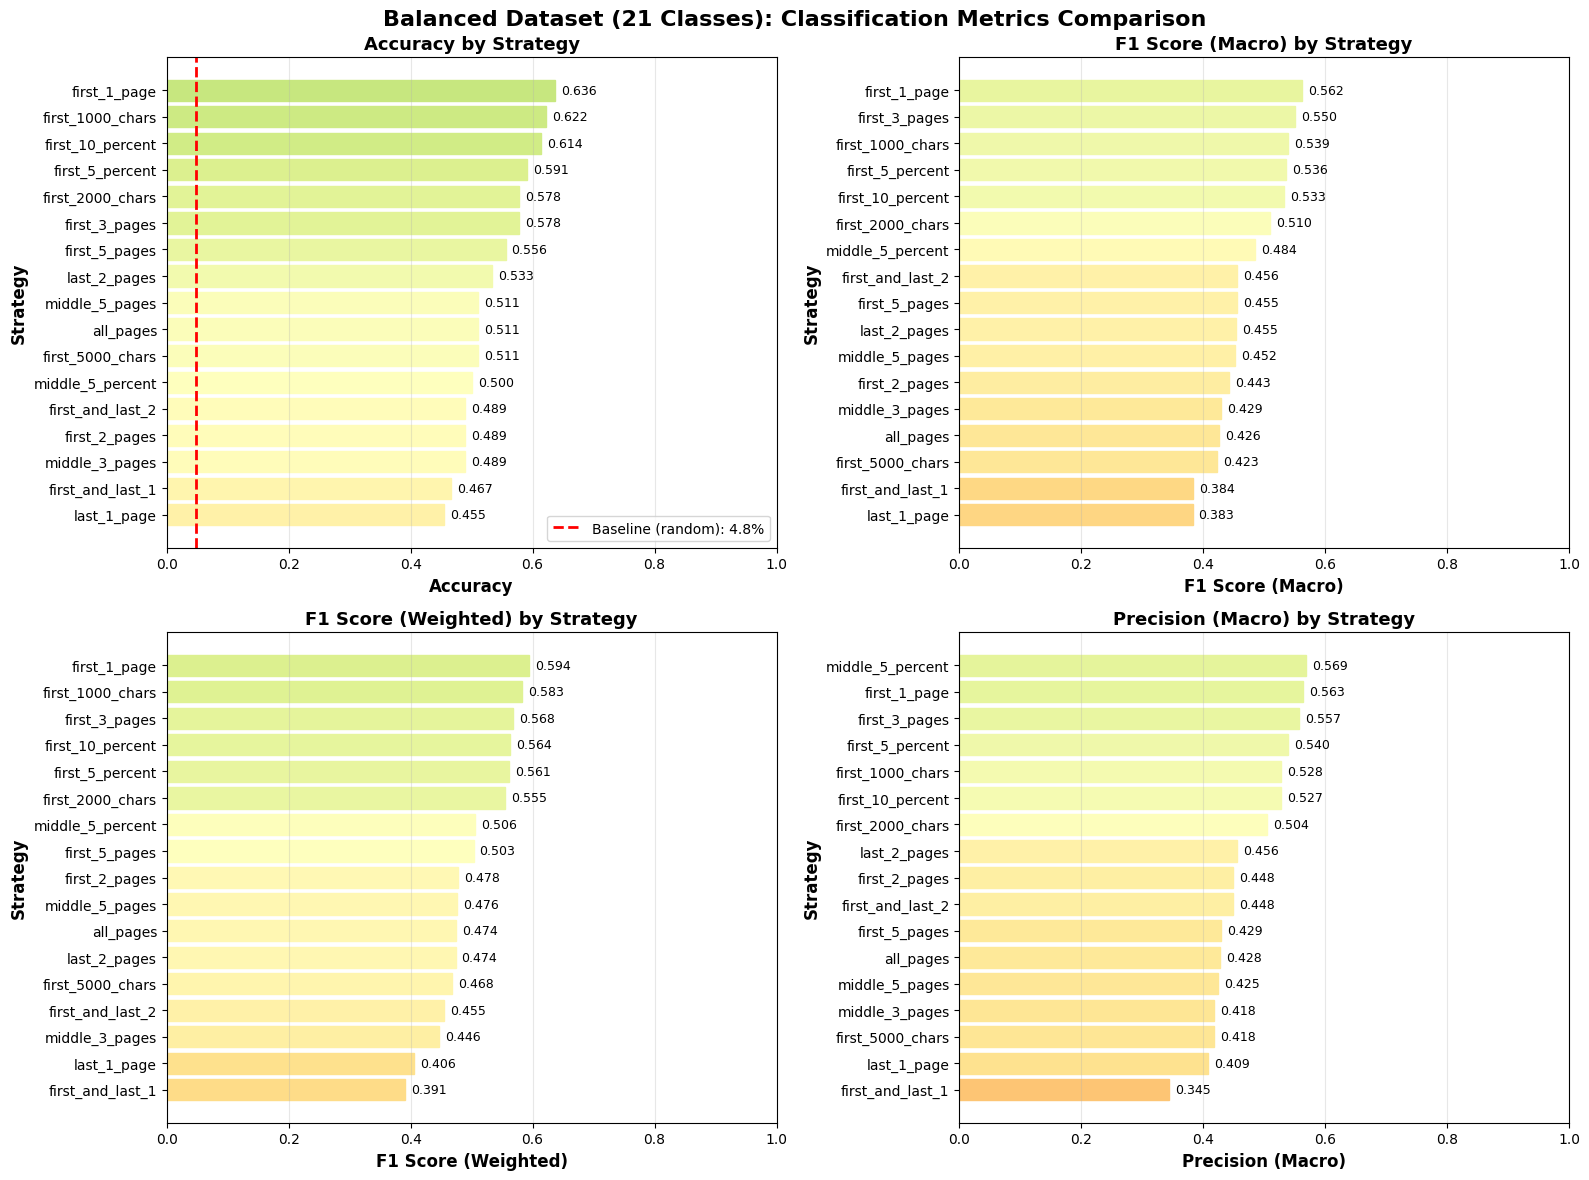

In [17]:
# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Balanced Dataset ({NUM_TAGS} Classes): Classification Metrics Comparison', fontsize=16, fontweight='bold')

metrics_to_plot = ['accuracy', 'f1_macro', 'f1_weighted', 'precision_macro']
titles = ['Accuracy', 'F1 Score (Macro)', 'F1 Score (Weighted)', 'Precision (Macro)']

for idx, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    ax = axes[idx // 2, idx % 2]
    
    sorted_df = results_df.sort_values(metric, ascending=True)
    
    bars = ax.barh(sorted_df['strategy'], sorted_df[metric])
    colors = plt.cm.RdYlGn(sorted_df[metric])
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    # Add baseline line for accuracy
    if metric == 'accuracy':
        ax.axvline(x=BASELINE_RANDOM, color='red', linestyle='--', linewidth=2, 
                   label=f'Baseline (random): {BASELINE_RANDOM*100:.1f}%')
        ax.legend()
    
    ax.set_xlabel(title, fontsize=12, fontweight='bold')
    ax.set_ylabel('Strategy', fontsize=12, fontweight='bold')
    ax.set_title(f'{title} by Strategy', fontsize=13, fontweight='bold')
    ax.set_xlim(0, 1.0)
    ax.grid(axis='x', alpha=0.3)
    
    for i, (strategy, value) in enumerate(zip(sorted_df['strategy'], sorted_df[metric])):
        ax.text(value + 0.01, i, f'{value:.3f}', va='center', fontsize=9)

plt.tight_layout()
plot_path = RESULTS_DIR / "metrics_comparison_all_tags.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"Plot saved to: {plot_path}")
plt.show()

In [18]:
# Best strategy
best_strategy = results_df.iloc[0]

print("\n" + "="*80)
print(f"BEST STRATEGY (Balanced Data - {NUM_TAGS} Classes)")
print("="*80)
print(f"\nStrategy: {best_strategy['strategy']}")
print(f"\nMetrics:")
print(f"  Accuracy:          {best_strategy['accuracy']:.4f}")
print(f"  F1 (macro):        {best_strategy['f1_macro']:.4f}")
print(f"  F1 (weighted):     {best_strategy['f1_weighted']:.4f}")
print(f"  Precision (macro): {best_strategy['precision_macro']:.4f}")
print(f"  Recall (macro):    {best_strategy['recall_macro']:.4f}")
print(f"\nImprovement over baseline: {(best_strategy['accuracy'] - BASELINE_RANDOM) / BASELINE_RANDOM * 100:.1f}%")
print("\n" + "="*80)


BEST STRATEGY (Balanced Data - 21 Classes)

Strategy: first_1_page

Metrics:
  Accuracy:          0.6364
  F1 (macro):        0.5617
  F1 (weighted):     0.5936
  Precision (macro): 0.5635
  Recall (macro):    0.6111

Improvement over baseline: 1236.4%



## Top 5 Strategies

In [19]:
top_5 = results_df.head(5)

print("\nTop 5 Strategies by F1 Score (Macro):")
print("="*80)
for idx, row in enumerate(top_5.itertuples(), 1):
    print(f"\n{idx}. {row.strategy}")
    print(f"   Accuracy:          {row.accuracy:.4f}")
    print(f"   F1 (macro):        {row.f1_macro:.4f}")
    print(f"   F1 (weighted):     {row.f1_weighted:.4f}")
    print(f"   Precision (macro): {row.precision_macro:.4f}")
    print(f"   Recall (macro):    {row.recall_macro:.4f}")
    print("   " + "-"*76)


Top 5 Strategies by F1 Score (Macro):

1. first_1_page
   Accuracy:          0.6364
   F1 (macro):        0.5617
   F1 (weighted):     0.5936
   Precision (macro): 0.5635
   Recall (macro):    0.6111
   ----------------------------------------------------------------------------

2. first_3_pages
   Accuracy:          0.5778
   F1 (macro):        0.5501
   F1 (weighted):     0.5683
   Precision (macro): 0.5571
   Recall (macro):    0.5714
   ----------------------------------------------------------------------------

3. first_1000_chars
   Accuracy:          0.6222
   F1 (macro):        0.5395
   F1 (weighted):     0.5826
   Precision (macro): 0.5278
   Recall (macro):    0.5873
   ----------------------------------------------------------------------------

4. first_5_percent
   Accuracy:          0.5909
   F1 (macro):        0.5361
   F1 (weighted):     0.5607
   Precision (macro): 0.5397
   Recall (macro):    0.5714
   --------------------------------------------------------------

## Save Complete Results

In [20]:
# Save experiment summary
experiment_summary = {
    'configuration': {
        'dataset_type': 'balanced',
        'selection_criteria': 'ALL tags with >10 samples',
        'num_classes': NUM_TAGS,
        'samples_per_class': min_class_size,
        'total_documents': len(balanced_dataset),
        'selected_tags': valid_tags,
        'train_ratio': TRAIN_RATIO,
        'k_neighbors': K_NEIGHBORS,
        'baseline_random_accuracy': BASELINE_RANDOM,
        'stratified_split': True,
        'embedding_service': f"{EMBEDDING_HOST}:{EMBEDDING_PORT}",
    },
    'strategies_tested': len(strategies),
    'successful_experiments': len(all_results),
    'best_strategy': {
        'name': best_strategy['strategy'],
        'accuracy': float(best_strategy['accuracy']),
        'f1_macro': float(best_strategy['f1_macro']),
        'f1_weighted': float(best_strategy['f1_weighted']),
        'precision_macro': float(best_strategy['precision_macro']),
        'recall_macro': float(best_strategy['recall_macro']),
    },
    'all_results': results_df.to_dict('records')
}

summary_path = RESULTS_DIR / "experiment_summary_all_tags.json"
with open(summary_path, 'w', encoding='utf-8') as f:
    json.dump(experiment_summary, f, indent=2, ensure_ascii=False)

print(f"\nExperiment summary saved to: {summary_path}")

NameError: name 'EMBEDDING_HOST' is not defined

## Additional Analysis: Class Distribution

In [ ]:
# Visualize which tags were included
plt.figure(figsize=(12, 6))
tag_distribution = balanced_dataset['document_tag'].value_counts().sort_index()
plt.bar(range(len(tag_distribution)), tag_distribution.values)
plt.xticks(range(len(tag_distribution)), tag_distribution.index, rotation=45, ha='right')
plt.xlabel('Document Tag', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')
plt.title(f'Balanced Dataset Distribution ({NUM_TAGS} Classes)', fontsize=14, fontweight='bold')
plt.axhline(y=min_class_size, color='red', linestyle='--', label=f'Balanced count: {min_class_size}')
plt.legend()
plt.tight_layout()
dist_plot_path = RESULTS_DIR / "class_distribution.png"
plt.savefig(dist_plot_path, dpi=300, bbox_inches='tight')
print(f"Class distribution plot saved to: {dist_plot_path}")
plt.show()